##  [ CM 3 ]
__KEVAL PRAJAPATI (20908584, kbprajap@uwaterloo.ca)__

__I have decided to create 3 separate networks for each of the target label namely: Confirmed, Deaths and Recovered__

In [20]:
# AUTHOR: KEVAL PRAJAPATI 
# IMPORTING NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from imblearn.pipeline import Pipeline
from math import exp, pow, floor
from tensorflow.keras.optimizers import Adam
import time

In [21]:
#Importing the hybrid dataset
df = pd.read_csv('D:\COLLEGE\Waterloo\TERM 1\ECE 657A\Assigments\Assignment 3\Dataset\hybrid_dataset.csv')

In [22]:
df.head()

,Day,State ID,Lat,Long_,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,PC1,PC2,Confirmed,Deaths,Recovered
0,2,1,-1.178670,0.304586,-0.200701,0.144028,-0.483568,-0.476902,-1.302217,-0.128626,-0.217091,0.118788,-1.168679,-24.223517,-14.514321,True,False,False
1,2,2,3.608919,-3.033032,-0.449116,-0.290315,-0.569578,-1.800519,2.071905,-0.754447,-0.276853,1.614954,3.492526,-23.151357,-14.474219,True,True,False
2,2,3,-0.946051,-0.945268,0.389194,0.088543,-0.007494,0.074416,-1.269412,0.181627,-0.239250,0.509092,0.385056,-22.252978,-14.510294,True,True,True
3,2,4,-0.741727,0.025825,-0.482520,0.202252,-0.456622,-0.031311,-0.559356,-0.422184,-0.242302,0.574143,-0.547185,-21.208164,-14.503685,True,True,True
4,2,5,-0.552794,-1.365662,4.276989,-0.502599,4.023547,-0.792949,-0.177608,4.905194,-0.122779,-0.922023,0.385056,-20.446867,-14.466792,True,True,False


__SPLITTING THE DATASET IN FEATURES AND LABELS__<br>
 I have divided the labels into 3 different one labels namely: Confirmed, Deaths, and Recovered

In [23]:
X = df.iloc[:,:-3]
YC = df.iloc[:,-3]
YD = df.iloc[:,-2]
YR = df.iloc[:,-1]

__Checking the balance of the each of the target labels__

In [24]:
print('Confirmed label counts:\n',YC.value_counts())
print('Death label counts:\n',YD.value_counts())
print('Recovered label counts:\n',YR.value_counts())

Confirmed label counts:
 True     1329
False      51
Name: Confirmed, dtype: int64
Death label counts:
 True     1244
False     136
Name: Deaths, dtype: int64
Recovered label counts:
 True     864
False    516
Name: Recovered, dtype: int64


__Balancing the target labels using data augmentation technique__<br>
 Using oversampling method for minority class and undersampling for majority class

In [25]:
oversample = SMOTE()
undersample=RandomUnderSampler()
steps = [("o",oversample),("u",undersample)]
pipeline  = Pipeline(steps=steps)


In [26]:
XC_sm, YC_sm = pipeline.fit_resample(X, YC)
XD_sm, YD_sm = pipeline.fit_resample(X, YD)
XR_sm, YR_sm = pipeline.fit_resample(X, YR)

__One hot encoding for target labels since I am using softmax activation function in output layer__

In [27]:
def OHE(Y):
    Y_OHE = to_categorical(Y, num_classes=2)
    return Y_OHE

YC_OHE = OHE(YC_sm)
YD_OHE = OHE(YD_sm)
YR_OHE = OHE(YR_sm)

In [34]:
# Splitting the dataset into train, test and validate sets
def split_data(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=15,stratify = Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=15,stratify = Y_train)
    return X_train, X_test, Y_train, Y_test, X_val, Y_val

# Defining the deep neural network 
def DNN(X,Y):
    # Splitting the dataset 
    X_train, X_test, Y_train, Y_test, X_val, Y_val = split_data(X,Y)
    # The model itself
    NN = models.Sequential([
        # Layer 1 with 64 nodes and ReLU activation function
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        
        # Layer 2 with 32 nodes and ReLU activation function
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        
        # Layer 3 with 16 nodes and ReLU activation function
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        
        #Output layer with 2 nodes and Softmax activation function
        layers.Dense(2, activation='softmax')    
    ])
    
    #Training 
    start_tr = time.process_time()
    NN.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    NN_scores=NN.fit(X_train, Y_train,validation_data =(X_val,Y_val), epochs=100)
    end_tr = time.process_time() - start_tr
    print('\n Training Time:',end_tr)
    
    #Testing 
    start_te = time.process_time()
    test_score = NN.evaluate(X_test, Y_test)
    end_te = time.process_time() - start_te
    print('\n Testing time:',end_te)
    print('Test loss:',test_score[0])
    print('Test accuracy: ',test_score[1])
    
    Y_pred_c = NN.predict_classes(X_test)
    Y_test_no=np.argmax(Y_test,axis=1)
    print('Classification_report:\n',classification_report(Y_test_no,Y_pred_c))
    
    #Confusion matrix
    print('\n Confusion matrix:')
    print(confusion_matrix(Y_test_no, Y_pred_c))
    
    #plot
    plt.plot(NN_scores.history['accuracy'])
    plt.plot(NN_scores.history['val_accuracy'])
    plt.title('Accuracy vs Training Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
    plt.plot(NN_scores.history['loss'])
    plt.plot(NN_scores.history['val_loss'])
    plt.title('Training Loss vs Training Epochs')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

__i) Neural network 1 for Confirmed label__

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

54/54 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.6894 - val_loss: 0.5030 - val_accuracy: 0.7817
Epoch 2/100
54/54 [==============================] - 0s 6ms/step - loss: 0.4642 - accuracy: 0.8153 - val_loss: 0.5195 - val_accuracy: 0.7864
Epoch 3/100
54/54 [==============================] - 0s 3ms/step - loss: 0.4317 - accuracy: 0.8218 - val_loss: 0.4351 - val_accuracy: 0.8404
Epoch 4/100
54/54 [==============================] - 0s 2ms/step - loss: 0.3695 - acc

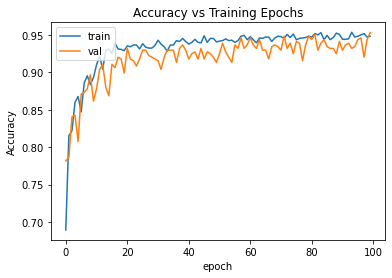

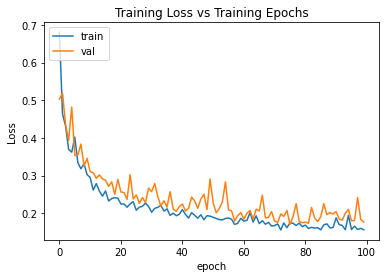

In [35]:
DNN(XC_sm,YC_OHE)

__ii) Neural network 2 for Death label__

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

50/50 [==============================] - 0s 5ms/step - loss: 0.7855 - accuracy: 0.6420 - val_loss: 0.5906 - val_accuracy: 0.7010
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 0.5630 - accuracy: 0.7368 - val_loss: 0.6227 - val_accuracy: 0.7286
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 0.5277 - accuracy: 0.7582 - val_loss: 0.5313 - val_accuracy: 0.7638
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.4864 - acc

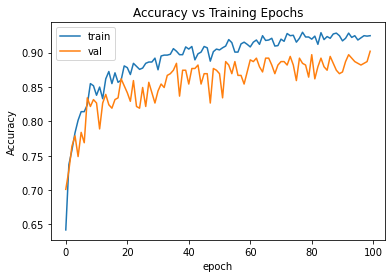

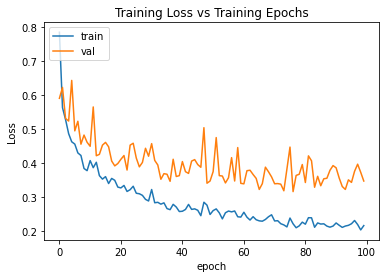

In [37]:
DNN(XD_sm,YD_OHE)

__iii) Neural network 3 for Recovered label__

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

35/35 [==============================] - 0s 7ms/step - loss: 0.7843 - accuracy: 0.6208 - val_loss: 0.5863 - val_accuracy: 0.7112
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 0.5541 - accuracy: 0.7294 - val_loss: 0.5398 - val_accuracy: 0.7148
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 0.4768 - accuracy: 0.7828 - val_loss: 0.4799 - val_accuracy: 0.8159
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 0.4454 - acc

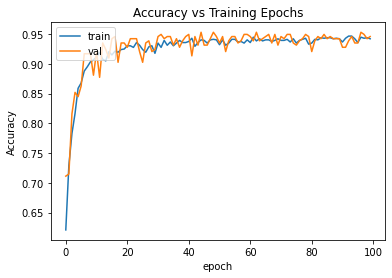

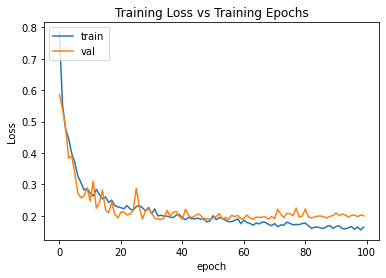

In [38]:
DNN(XR_sm,YR_OHE)